In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout

### Dataset

In [2]:
dataset = pd.read_csv('../../data/zeda/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset[:]
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [3]:
# data.tail(10)

### Dataset Information

In [4]:
print(list(data.columns))

['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A', 'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B', 'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26', 'TWS_S26', 'PUMP_S26', 'MEAN_RAIN']


### Pre-processing

In [5]:
# specify the number of lag hours
n_hours = 24*7
K = 24

#### Stage

In [6]:
# Pre-processing
# Stage --> 8 stages
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)

# stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96241, 768)


In [7]:
# stages_supervised

In [8]:
stages_head = dataset[['HWS_S25A', 'HWS_S25B', 'HWS_S26']]
print("stages_head.shape:", stages_head.shape)

# stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
stages_head_supervised = series_to_supervised(stages_head, n_hours, K)
print("stages_head_supervised.shape:", stages_head_supervised.shape)

stages_head.shape: (96432, 3)
stages_head_supervised.shape: (96241, 576)


In [9]:
# stages_head_supervised

#### Non-stage

In [10]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
print("non_stages.shape:", non_stages.shape)

non_stages_supervised = series_to_supervised(non_stages, n_hours-1, 1)
print("non_stages_supervised.shape:", non_stages_supervised.shape)

non_stages.shape: (96432, 12)
non_stages_supervised.shape: (96265, 2016)


In [11]:
# non_stages_supervised

In [12]:
non_stages_supervised_cut = non_stages_supervised.iloc[24:, :]
print("non_stages_supervised_cut.shape:", non_stages_supervised_cut.shape)

non_stages_supervised_cut.shape: (96241, 2016)


In [13]:
# non_stages_supervised_cut

### N_out, N_in, K

In [14]:
# specify the number of lag hours
# n_hours = 72
n_features = stages_head.shape[1] + stages.shape[1] + non_stages.shape[1]   # 1 rainfall + FGate_S25A + FGate_S25B + FGate_S26 + 8WS + PUMP_S26
# K = 12

### Concatenation

In [15]:
stages_head_supervised.reset_index(drop=True, inplace=True)
non_stages_supervised_cut.reset_index(drop=True, inplace=True)
stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([
                   non_stages_supervised_cut.iloc[:, :],
                   stages_head_supervised.iloc[:, :-3*K],
                   stages_supervised.iloc[:, :]],
                   axis=1)

In [16]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96241, 3288)


In [17]:
# all_concat = pd.DataFrame(all_data)
# all_concat

### Train & Test set

In [18]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test = all_data[n_train_hours:, :]

n_train_hours: 76992


In [19]:
train.shape

(76992, 3288)

In [20]:
n_hours

168

In [21]:
n_features

19

### Normalization

In [22]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -stages.shape[1]*K:]
test_X, test_y = test[:, :n_obs], test[:, -stages.shape[1]*K:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (76992, 3192) (76992, 96) (19249, 3192) (19249, 96)


In [23]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (76992, 168, 19) (76992, 96) (19249, 168, 19) (19249, 96)


### Model

- LSTM(64), no dropout, 2000 epoch --> 0.0016

In [27]:
# design network return_sequences=True, 
model_lstm_60 = Sequential()
model_lstm_60.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# model_lstm_60.add(Dropout(0.1))

# model_lstm_60.add(Dense(16))
# model_lstm_60.add(Dropout(0.3))
model_lstm_60.add(Dense(train_y.shape[1]))
model_lstm_60.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                21504     
                                                                 
 dense_2 (Dense)             (None, 96)                6240      
                                                                 
Total params: 27,744
Trainable params: 27,744
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
301/301 - 37s - loss: 5.7578e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0315 - 37s/epoch - 121ms/step
Epoch 2/500
301/301 - 35s - loss: 5.7797e-04 - mae: 0.0174 - val_loss: 0.0017 - val_mae: 0.0317 - 35s/epoch - 116ms/step
Epoch 3/500
301/301 - 35s - loss: 5.7834e-04 - mae: 0.0174 - val_loss: 0.0017 - val_mae: 0.0319 - 35s/epoch - 116ms/step
Epoch 4/500
301/301 - 36s - loss: 5.7811e-04 - mae: 0.0174 - val_loss: 0.0017 - val_mae: 0.0318 - 36s/epoch - 119ms/step
Epoch 5/500
301/301 - 36s - loss: 5.7847e-04 - mae: 0.0174 - val_loss: 0.0017 - val_mae: 0.0320 - 36s/epoch - 118ms/step
Epoch 6/500
301/301 - 34s - loss: 5.7773e-04 - mae: 0.0174 - val_loss: 0.0017 - val_mae: 0.0318 - 34s/epoch - 113ms/step
Epoch 7/500
301/301 - 35s - loss: 5.7944e-04 - mae: 0.0174 - val_loss: 0.0017 - val_mae: 0.0324 - 35s/epoch - 115ms/step
Epoch 8/500
301/301 - 37s - loss: 5.7837e-04 - mae: 0.0174 - val_loss: 0.0017 - val_mae: 0.0319 - 37s/epoch - 124ms/step
Epoch 9/500
301/301 - 47s - loss

Epoch 69/500
301/301 - 34s - loss: 5.6865e-04 - mae: 0.0172 - val_loss: 0.0017 - val_mae: 0.0319 - 34s/epoch - 114ms/step
Epoch 70/500
301/301 - 34s - loss: 5.6857e-04 - mae: 0.0172 - val_loss: 0.0017 - val_mae: 0.0319 - 34s/epoch - 113ms/step
Epoch 71/500
301/301 - 35s - loss: 5.6848e-04 - mae: 0.0172 - val_loss: 0.0017 - val_mae: 0.0319 - 35s/epoch - 115ms/step
Epoch 72/500
301/301 - 34s - loss: 5.6835e-04 - mae: 0.0172 - val_loss: 0.0017 - val_mae: 0.0319 - 34s/epoch - 114ms/step
Epoch 73/500
301/301 - 34s - loss: 5.6820e-04 - mae: 0.0172 - val_loss: 0.0017 - val_mae: 0.0319 - 34s/epoch - 113ms/step
Epoch 74/500
301/301 - 34s - loss: 5.6801e-04 - mae: 0.0172 - val_loss: 0.0017 - val_mae: 0.0319 - 34s/epoch - 113ms/step
Epoch 75/500
301/301 - 34s - loss: 5.6779e-04 - mae: 0.0172 - val_loss: 0.0017 - val_mae: 0.0319 - 34s/epoch - 113ms/step
Epoch 76/500
301/301 - 34s - loss: 5.6759e-04 - mae: 0.0172 - val_loss: 0.0017 - val_mae: 0.0319 - 34s/epoch - 113ms/step
Epoch 77/500
301/301 - 3

Epoch 136/500
301/301 - 34s - loss: 5.5873e-04 - mae: 0.0171 - val_loss: 0.0017 - val_mae: 0.0319 - 34s/epoch - 114ms/step
Epoch 137/500
301/301 - 34s - loss: 5.5839e-04 - mae: 0.0171 - val_loss: 0.0017 - val_mae: 0.0319 - 34s/epoch - 113ms/step
Epoch 138/500
301/301 - 34s - loss: 5.5843e-04 - mae: 0.0171 - val_loss: 0.0017 - val_mae: 0.0320 - 34s/epoch - 114ms/step
Epoch 139/500
301/301 - 34s - loss: 5.5815e-04 - mae: 0.0171 - val_loss: 0.0017 - val_mae: 0.0320 - 34s/epoch - 114ms/step
Epoch 140/500
301/301 - 34s - loss: 5.5881e-04 - mae: 0.0171 - val_loss: 0.0017 - val_mae: 0.0321 - 34s/epoch - 114ms/step
Epoch 141/500
301/301 - 34s - loss: 5.5847e-04 - mae: 0.0171 - val_loss: 0.0017 - val_mae: 0.0320 - 34s/epoch - 114ms/step
Epoch 142/500
301/301 - 34s - loss: 5.5856e-04 - mae: 0.0171 - val_loss: 0.0017 - val_mae: 0.0320 - 34s/epoch - 114ms/step
Epoch 143/500
301/301 - 34s - loss: 5.5812e-04 - mae: 0.0171 - val_loss: 0.0017 - val_mae: 0.0320 - 34s/epoch - 113ms/step
Epoch 144/500
30

Epoch 203/500
301/301 - 34s - loss: 5.5105e-04 - mae: 0.0170 - val_loss: 0.0018 - val_mae: 0.0321 - 34s/epoch - 114ms/step
Epoch 204/500
301/301 - 34s - loss: 5.4943e-04 - mae: 0.0170 - val_loss: 0.0017 - val_mae: 0.0320 - 34s/epoch - 113ms/step
Epoch 205/500
301/301 - 34s - loss: 5.5039e-04 - mae: 0.0170 - val_loss: 0.0017 - val_mae: 0.0322 - 34s/epoch - 114ms/step
Epoch 206/500
301/301 - 34s - loss: 5.5033e-04 - mae: 0.0170 - val_loss: 0.0018 - val_mae: 0.0321 - 34s/epoch - 113ms/step
Epoch 207/500
301/301 - 34s - loss: 5.4911e-04 - mae: 0.0170 - val_loss: 0.0017 - val_mae: 0.0320 - 34s/epoch - 114ms/step
Epoch 208/500
301/301 - 35s - loss: 5.4897e-04 - mae: 0.0170 - val_loss: 0.0017 - val_mae: 0.0320 - 35s/epoch - 115ms/step
Epoch 209/500
301/301 - 34s - loss: 5.4938e-04 - mae: 0.0170 - val_loss: 0.0017 - val_mae: 0.0320 - 34s/epoch - 113ms/step
Epoch 210/500
301/301 - 34s - loss: 5.4878e-04 - mae: 0.0170 - val_loss: 0.0017 - val_mae: 0.0320 - 34s/epoch - 113ms/step
Epoch 211/500
30

Epoch 270/500
301/301 - 34s - loss: 5.4141e-04 - mae: 0.0169 - val_loss: 0.0018 - val_mae: 0.0321 - 34s/epoch - 114ms/step
Epoch 271/500
301/301 - 34s - loss: 5.4143e-04 - mae: 0.0169 - val_loss: 0.0018 - val_mae: 0.0321 - 34s/epoch - 114ms/step
Epoch 272/500
301/301 - 35s - loss: 5.4095e-04 - mae: 0.0169 - val_loss: 0.0018 - val_mae: 0.0321 - 35s/epoch - 115ms/step
Epoch 273/500
301/301 - 34s - loss: 5.4302e-04 - mae: 0.0169 - val_loss: 0.0017 - val_mae: 0.0321 - 34s/epoch - 114ms/step
Epoch 274/500
301/301 - 34s - loss: 5.4292e-04 - mae: 0.0169 - val_loss: 0.0018 - val_mae: 0.0322 - 34s/epoch - 113ms/step
Epoch 275/500
301/301 - 34s - loss: 5.4245e-04 - mae: 0.0169 - val_loss: 0.0018 - val_mae: 0.0322 - 34s/epoch - 113ms/step
Epoch 276/500
301/301 - 34s - loss: 5.4162e-04 - mae: 0.0169 - val_loss: 0.0018 - val_mae: 0.0323 - 34s/epoch - 114ms/step
Epoch 277/500
301/301 - 34s - loss: 5.4127e-04 - mae: 0.0169 - val_loss: 0.0018 - val_mae: 0.0323 - 34s/epoch - 114ms/step
Epoch 278/500
30

Epoch 337/500
301/301 - 34s - loss: 5.3678e-04 - mae: 0.0168 - val_loss: 0.0017 - val_mae: 0.0321 - 34s/epoch - 113ms/step
Epoch 338/500
301/301 - 35s - loss: 5.3684e-04 - mae: 0.0168 - val_loss: 0.0018 - val_mae: 0.0323 - 35s/epoch - 115ms/step
Epoch 339/500
301/301 - 34s - loss: 5.3629e-04 - mae: 0.0168 - val_loss: 0.0018 - val_mae: 0.0324 - 34s/epoch - 112ms/step
Epoch 340/500
301/301 - 34s - loss: 5.3413e-04 - mae: 0.0168 - val_loss: 0.0018 - val_mae: 0.0323 - 34s/epoch - 113ms/step
Epoch 341/500
301/301 - 34s - loss: 5.3417e-04 - mae: 0.0167 - val_loss: 0.0018 - val_mae: 0.0323 - 34s/epoch - 114ms/step
Epoch 342/500
301/301 - 34s - loss: 5.3379e-04 - mae: 0.0167 - val_loss: 0.0018 - val_mae: 0.0323 - 34s/epoch - 114ms/step
Epoch 343/500
301/301 - 34s - loss: 5.3491e-04 - mae: 0.0168 - val_loss: 0.0018 - val_mae: 0.0322 - 34s/epoch - 114ms/step
Epoch 344/500
301/301 - 34s - loss: 5.3371e-04 - mae: 0.0167 - val_loss: 0.0018 - val_mae: 0.0323 - 34s/epoch - 113ms/step
Epoch 345/500
30

Epoch 404/500
301/301 - 34s - loss: 5.2939e-04 - mae: 0.0167 - val_loss: 0.0017 - val_mae: 0.0321 - 34s/epoch - 113ms/step
Epoch 405/500
301/301 - 34s - loss: 5.2807e-04 - mae: 0.0166 - val_loss: 0.0018 - val_mae: 0.0323 - 34s/epoch - 113ms/step
Epoch 406/500
301/301 - 34s - loss: 5.2793e-04 - mae: 0.0166 - val_loss: 0.0018 - val_mae: 0.0322 - 34s/epoch - 113ms/step
Epoch 407/500
301/301 - 34s - loss: 5.2712e-04 - mae: 0.0166 - val_loss: 0.0018 - val_mae: 0.0323 - 34s/epoch - 114ms/step
Epoch 408/500
301/301 - 34s - loss: 5.2882e-04 - mae: 0.0167 - val_loss: 0.0018 - val_mae: 0.0321 - 34s/epoch - 113ms/step
Epoch 409/500
301/301 - 34s - loss: 5.2739e-04 - mae: 0.0166 - val_loss: 0.0018 - val_mae: 0.0323 - 34s/epoch - 113ms/step
Epoch 410/500
301/301 - 34s - loss: 5.2845e-04 - mae: 0.0167 - val_loss: 0.0018 - val_mae: 0.0322 - 34s/epoch - 113ms/step
Epoch 411/500
301/301 - 34s - loss: 5.2734e-04 - mae: 0.0166 - val_loss: 0.0018 - val_mae: 0.0323 - 34s/epoch - 114ms/step
Epoch 412/500
30

Epoch 471/500
301/301 - 34s - loss: 5.2316e-04 - mae: 0.0166 - val_loss: 0.0018 - val_mae: 0.0325 - 34s/epoch - 113ms/step
Epoch 472/500
301/301 - 35s - loss: 5.2528e-04 - mae: 0.0166 - val_loss: 0.0018 - val_mae: 0.0320 - 35s/epoch - 115ms/step
Epoch 473/500
301/301 - 34s - loss: 5.2037e-04 - mae: 0.0165 - val_loss: 0.0018 - val_mae: 0.0324 - 34s/epoch - 114ms/step
Epoch 474/500
301/301 - 35s - loss: 5.2145e-04 - mae: 0.0165 - val_loss: 0.0018 - val_mae: 0.0323 - 35s/epoch - 115ms/step
Epoch 475/500
301/301 - 34s - loss: 5.2064e-04 - mae: 0.0165 - val_loss: 0.0018 - val_mae: 0.0324 - 34s/epoch - 114ms/step
Epoch 476/500
301/301 - 34s - loss: 5.2310e-04 - mae: 0.0166 - val_loss: 0.0017 - val_mae: 0.0320 - 34s/epoch - 113ms/step
Epoch 477/500
301/301 - 34s - loss: 5.2174e-04 - mae: 0.0165 - val_loss: 0.0018 - val_mae: 0.0324 - 34s/epoch - 114ms/step
Epoch 478/500
301/301 - 34s - loss: 5.2174e-04 - mae: 0.0165 - val_loss: 0.0018 - val_mae: 0.0322 - 34s/epoch - 114ms/step
Epoch 479/500
30

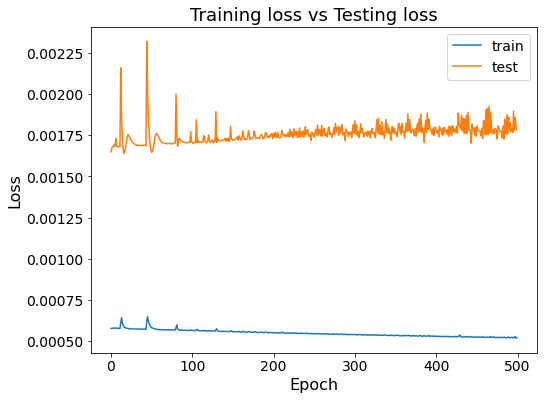

In [40]:
lr = 0.00001
EPOCHS = 2000
model_lstm_60.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

history = model_lstm_60.fit(train_X, train_y,
                    batch_size=256,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False)

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [54]:
# # Save the entire model as a SavedModel.
# !mkdir -p saved_model
model_lstm_60.save('saved_model/lstm_withflow')

INFO:tensorflow:Assets written to: saved_model/lstm_withflow/assets


In [55]:
# from keras.models import load_model

# model_load = load_model('saved_model/model_lstm_60')

### Prediction

#### Test set

In [41]:
yhat = model_lstm_60.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

602/602 [==============================] - 8s 13ms/step
inv_y.shape, inv_yhat.shape (19249, 96) (19249, 96)


In [42]:
# yhat = model_load.predict(test_X)
# inv_yhat = scaler.inverse_transform(yhat)
# inv_y = scaler.inverse_transform(test_y)

# inv_yhat = pd.DataFrame(inv_yhat)
# inv_y = pd.DataFrame(inv_y)
# print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

In [43]:
inv_y

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.17,0.20,0.27,0.23,0.22,0.23,0.28,0.26,0.56,0.61,...,1.97,1.95,1.36,1.39,1.48,1.43,0.94,0.98,1.07,1.01
1,0.22,0.23,0.28,0.26,0.56,0.61,0.62,0.60,1.05,1.06,...,1.48,1.43,0.94,0.98,1.07,1.01,0.44,0.44,0.58,0.51
2,0.56,0.61,0.62,0.60,1.05,1.06,1.07,1.07,1.46,1.47,...,1.07,1.01,0.44,0.44,0.58,0.51,0.35,0.39,0.42,0.38
3,1.05,1.06,1.07,1.07,1.46,1.47,1.50,1.51,1.88,1.94,...,0.58,0.51,0.35,0.39,0.42,0.38,0.56,0.57,0.62,0.60
4,1.46,1.47,1.50,1.51,1.88,1.94,1.93,1.91,2.05,2.05,...,0.42,0.38,0.56,0.57,0.62,0.60,1.03,1.03,1.08,1.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19244,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
19245,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
19246,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
19247,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


In [44]:
inv_yhat

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.090246,0.175998,0.260980,0.368710,0.186426,0.216129,0.331817,0.490938,0.472754,0.546825,...,1.762761,1.867098,1.257715,1.316430,1.312672,1.405040,0.695058,0.848406,0.862804,0.945937
1,0.157497,0.205693,0.300947,0.456588,0.522900,0.522357,0.622576,0.847398,0.939612,0.986651,...,1.459629,1.540752,0.881765,0.947213,0.998693,1.026643,0.389079,0.525282,0.598713,0.636621
2,0.427809,0.458880,0.559751,0.742455,0.940279,0.938186,1.015564,1.291686,1.433283,1.443877,...,1.016445,1.054337,0.438041,0.549496,0.626998,0.610179,0.220970,0.300611,0.400842,0.417233
3,0.953925,0.948582,1.007169,1.171021,1.444240,1.468763,1.504033,1.726170,1.840816,1.887774,...,0.636506,0.666610,0.264026,0.354064,0.425585,0.418598,0.335139,0.393549,0.466483,0.480057
4,1.443708,1.444590,1.478965,1.627288,1.849294,1.883685,1.911610,2.141377,2.087675,2.155802,...,0.486180,0.489399,0.390285,0.473677,0.564557,0.561656,0.706625,0.767518,0.811879,0.866737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19244,1.894996,1.945587,1.943757,2.159659,2.153658,2.185420,2.206399,2.515475,2.020996,2.174392,...,0.249267,0.327859,0.536743,0.557473,0.642789,0.733652,0.982926,1.070123,1.069556,1.256147
19245,2.092685,2.170519,2.124445,2.387358,2.063655,2.147701,2.158850,2.498716,1.682474,1.863644,...,0.642051,0.760893,1.071895,1.083918,1.155515,1.272182,1.480612,1.563230,1.537864,1.757143
19246,2.075633,2.191373,2.110839,2.364505,1.690953,1.813237,1.834993,2.123657,1.163671,1.319655,...,1.133507,1.274550,1.577748,1.581357,1.623815,1.758227,1.898695,1.939622,1.931576,2.102078
19247,1.744981,1.862084,1.782430,1.931234,1.141609,1.275396,1.334818,1.487091,0.639684,0.769870,...,1.584963,1.703293,1.986790,1.972319,1.958642,2.104876,2.104166,2.173844,2.134511,2.231947


In [45]:
error_abs_60min_lstm = abs(inv_yhat - inv_y)
error_abs_60min_lstm

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.079754,0.024002,0.009020,0.138710,0.033574,0.013871,0.051817,0.230938,0.087246,0.063175,...,0.207239,0.082902,0.102285,0.073570,0.167328,0.024960,0.244942,0.131594,0.207196,6.406296e-02
1,0.062503,0.024307,0.020947,0.196588,0.037100,0.087643,0.002576,0.247398,0.110388,0.073349,...,0.020371,0.110752,0.058235,0.032787,0.071307,0.016643,0.050921,0.085282,0.018713,1.266210e-01
2,0.132191,0.151120,0.060249,0.142455,0.109721,0.121814,0.054436,0.221686,0.026717,0.026123,...,0.053555,0.044337,0.001959,0.109496,0.046998,0.100179,0.129030,0.089389,0.019158,3.723311e-02
3,0.096075,0.111418,0.062831,0.101021,0.015760,0.001237,0.004033,0.216170,0.039184,0.052226,...,0.056506,0.156610,0.085974,0.035936,0.005585,0.038598,0.224861,0.176451,0.153517,1.199432e-01
4,0.016292,0.025410,0.021035,0.117288,0.030706,0.056315,0.018390,0.231377,0.037675,0.105802,...,0.066180,0.109399,0.169715,0.096323,0.055443,0.038344,0.323375,0.262482,0.268121,1.932632e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19244,0.035004,0.004413,0.056243,0.159659,0.036342,0.024580,0.043601,0.265475,0.089004,0.054392,...,0.019267,0.117859,0.233257,0.182527,0.107211,0.016348,0.257074,0.179877,0.240444,3.385297e-02
19245,0.097315,0.039481,0.125555,0.137358,0.046345,0.027701,0.061150,0.308716,0.032474,0.173644,...,0.107949,0.010893,0.168105,0.166082,0.154485,0.017818,0.139388,0.076770,0.142136,9.714254e-02
19246,0.034367,0.071373,0.109161,0.174505,0.040953,0.123237,0.074993,0.403657,0.076329,0.079655,...,0.176493,0.015450,0.042252,0.058643,0.056185,0.098227,0.081305,0.060378,0.108424,6.207796e-02
19247,0.094981,0.172084,0.022430,0.211234,0.098391,0.035396,0.035182,0.167091,0.120316,0.039870,...,0.095037,0.043293,0.006790,0.027681,0.081358,0.064876,0.025834,0.043844,0.075489,5.194671e-02


In [46]:
error_60min_lstm = inv_yhat - inv_y
error_60min_lstm

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-0.079754,-0.024002,-0.009020,0.138710,-0.033574,-0.013871,0.051817,0.230938,-0.087246,-0.063175,...,-0.207239,-0.082902,-0.102285,-0.073570,-0.167328,-0.024960,-0.244942,-0.131594,-0.207196,-6.406296e-02
1,-0.062503,-0.024307,0.020947,0.196588,-0.037100,-0.087643,0.002576,0.247398,-0.110388,-0.073349,...,-0.020371,0.110752,-0.058235,-0.032787,-0.071307,0.016643,-0.050921,0.085282,0.018713,1.266210e-01
2,-0.132191,-0.151120,-0.060249,0.142455,-0.109721,-0.121814,-0.054436,0.221686,-0.026717,-0.026123,...,-0.053555,0.044337,-0.001959,0.109496,0.046998,0.100179,-0.129030,-0.089389,-0.019158,3.723311e-02
3,-0.096075,-0.111418,-0.062831,0.101021,-0.015760,-0.001237,0.004033,0.216170,-0.039184,-0.052226,...,0.056506,0.156610,-0.085974,-0.035936,0.005585,0.038598,-0.224861,-0.176451,-0.153517,-1.199432e-01
4,-0.016292,-0.025410,-0.021035,0.117288,-0.030706,-0.056315,-0.018390,0.231377,0.037675,0.105802,...,0.066180,0.109399,-0.169715,-0.096323,-0.055443,-0.038344,-0.323375,-0.262482,-0.268121,-1.932632e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19244,-0.035004,-0.004413,-0.056243,0.159659,-0.036342,-0.024580,-0.043601,0.265475,-0.089004,0.054392,...,0.019267,0.117859,-0.233257,-0.182527,-0.107211,-0.016348,-0.257074,-0.179877,-0.240444,-3.385297e-02
19245,-0.097315,-0.039481,-0.125555,0.137358,-0.046345,0.027701,-0.061150,0.308716,0.032474,0.173644,...,-0.107949,0.010893,-0.168105,-0.166082,-0.154485,-0.017818,-0.139388,-0.076770,-0.142136,9.714254e-02
19246,-0.034367,0.071373,-0.109161,0.174505,0.040953,0.123237,0.074993,0.403657,-0.076329,0.079655,...,-0.176493,-0.015450,-0.042252,-0.058643,-0.056185,0.098227,-0.081305,-0.060378,-0.108424,6.207796e-02
19247,0.094981,0.172084,0.022430,0.211234,-0.098391,0.035396,-0.035182,0.167091,-0.120316,0.039870,...,-0.095037,0.043293,0.006790,-0.027681,-0.081358,0.064876,-0.025834,0.043844,-0.075489,5.194671e-02


In [47]:
## 17544 = 24 * (365+366)
error_19_20 = error_60min_lstm.iloc[-17544:, :]
error_19_20_lstm_df = pd.DataFrame(error_19_20)
error_19_20_lstm_df.to_csv('output/error_19_20_lstm_df_withflow.csv')

In [48]:
len(error_19_20_lstm_df)

17544

In [49]:
inv_y.to_csv('./output/inv_y_60min_lstm_withflow.csv')
inv_yhat.to_csv('./output/inv_yhat_60min_lstm_withflow.csv')
# error_abs_60min_lstm.to_csv('./output/error_abs_60min_lstm_withflow.csv')
error_60min_lstm.to_csv('./output/error_60min_lstm_withflow.csv')

### Performance

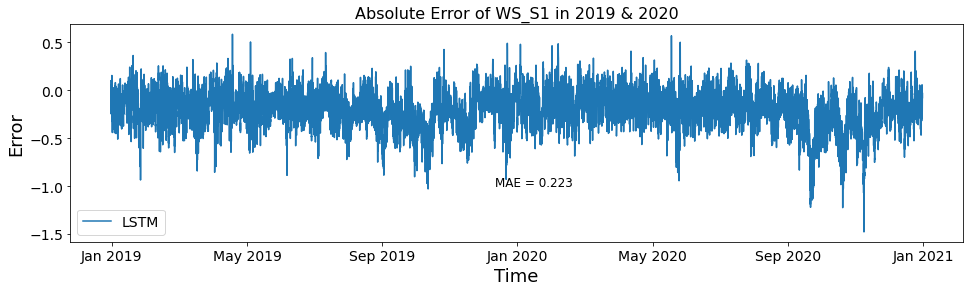

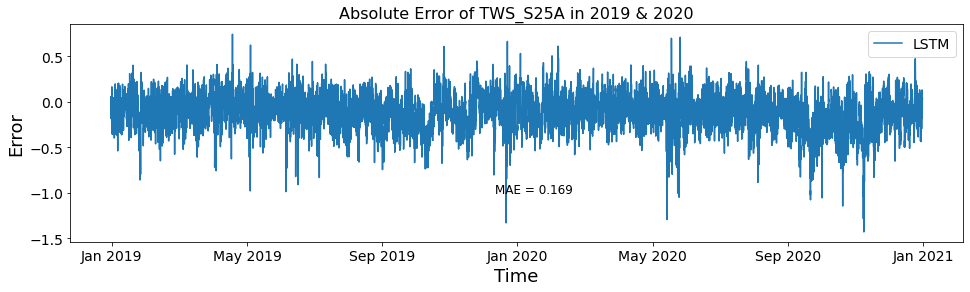

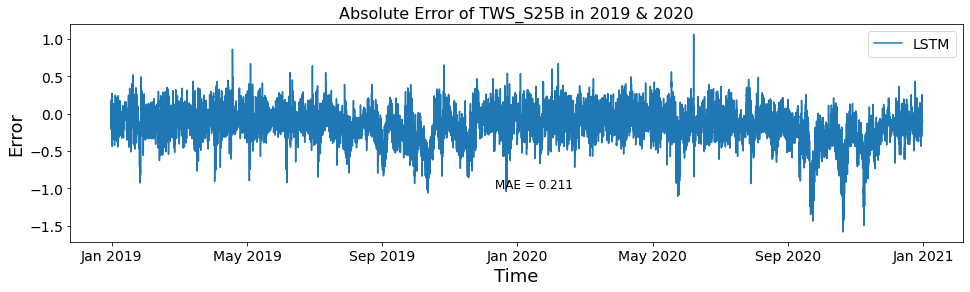

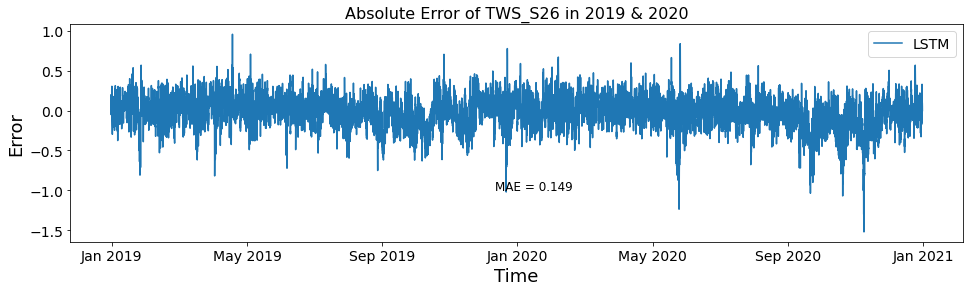

In [50]:
plt.rcParams["figure.figsize"] = (16, 4)
months = ['Jan 2019', 'May 2019', 'Sep 2019', 'Jan 2020', 'May 2020', 'Sep 2020', 'Jan 2021']

# 17544 = 24 hours * (365+366) days
locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
for i, col in enumerate([-4, -3, -2, -1]):
    plt.plot(error_60min_lstm.iloc[-17544:, col], label='LSTM')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Error', fontsize=18)
    plt.xticks(np.arange(1726, 19270, 2923), months, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.title('Absolute Error of {} in 2019 & 2020'.format(locations[i]), fontsize=16)
    # plt.savefig('figures/Test_Error_rnn_chop.png', dpi=300)
    plt.text(10000, -1, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error_60min_lstm.iloc[-17544:, col]))/17544))), fontsize=12)
    plt.show()
    plt.close()

In [51]:
error1 = error_60min_lstm.iloc[-17064:, [-4, -3, -2, -1]]
error1

,92,93,94,95
2185,-0.099041,0.071641,0.097247,1.002170e-01
2186,0.059763,0.203517,0.306981,2.812711e-01
2187,0.275327,0.358787,0.483220,5.059004e-01
2188,0.363896,0.403508,0.520848,5.361027e-01
2189,0.218680,0.329596,0.305951,4.178308e-01
...,...,...,...,...
19244,-0.257074,-0.179877,-0.240444,-3.385297e-02
19245,-0.139388,-0.076770,-0.142136,9.714254e-02
19246,-0.081305,-0.060378,-0.108424,6.207796e-02
19247,-0.025834,0.043844,-0.075489,5.194671e-02


In [52]:
error1.columns = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
error1

,WS_S1,TWS_S25A,TWS_S25B,TWS_S26
2185,-0.099041,0.071641,0.097247,1.002170e-01
2186,0.059763,0.203517,0.306981,2.812711e-01
2187,0.275327,0.358787,0.483220,5.059004e-01
2188,0.363896,0.403508,0.520848,5.361027e-01
2189,0.218680,0.329596,0.305951,4.178308e-01
...,...,...,...,...
19244,-0.257074,-0.179877,-0.240444,-3.385297e-02
19245,-0.139388,-0.076770,-0.142136,9.714254e-02
19246,-0.081305,-0.060378,-0.108424,6.207796e-02
19247,-0.025834,0.043844,-0.075489,5.194671e-02


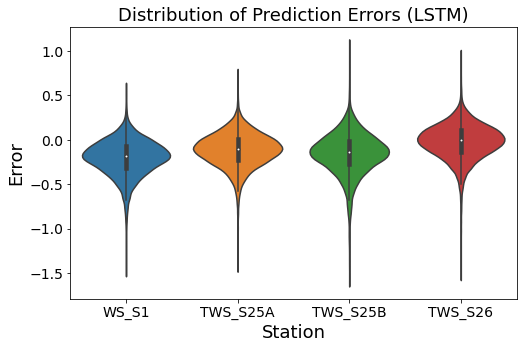

In [53]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 5)
# plt.grid()
plt.xlabel('Station', fontsize=18)
plt.ylabel('Error', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Distribution of Prediction Errors (LSTM)', fontsize='18')
ax = sns.violinplot(data=error1[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']])

In [26]:
# Whole test set: WS = ['WS_S1', 'WS_S4', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
RMSES, MAES = [], []
for i in range(inv_yhat.shape[1]):
    RMSE = sqrt(mean_squared_error(inv_y.iloc[:, i], inv_yhat.iloc[:, i]))
    MAE = mean_absolute_error(inv_y.iloc[:, i], inv_yhat.iloc[:, i])
    RMSES.append(float("{:.4f}".format(RMSE)))
    MAES.append(float("{:.4f}".format(MAE)))
print("Test RMSE for WS_S1, WS_S4, TWS_S25A, TWS_S25B, TWS_S26:", RMSES)
print("Test MAE for WS_S1, WS_S4, TWS_S25A, TWS_S25B, TWS_S26:", MAES)


# # 'WS_S1', 'WS_S4', 'TWS_S25A', 'TWS_S25B', 'TWS_S26', 'HWS_S25A', 'HWS_S25B', 'HWS_S26'
# plt.rcParams["figure.figsize"] = (8, 6)
# plt.title('Comparison RMSE & MAE at Different Locations', fontsize=18)
# plt.plot(RMSES, label='RMSE', marker='D')
# plt.plot(MAES, label='MAE', marker='o')
# plt.xlabel('Locations', fontsize=16)
# plt.ylabel('Error', fontsize=16)
# plt.xticks(np.arange(5), ['S1', 'S4', 'S25A', 'S25B', 'S26'], fontsize=14)
# plt.yticks(fontsize=14)
# # plt.axhline(y=0.15, color='red', linestyle='-', linewidth=2)
# # plt.axhline(y=0.25, color='orange', linestyle='-', linewidth=2)
# # plt.text(0, 0.26, 'R=0.25', fontsize=14)
# # plt.text(0, 0.16, 'R=0.15', fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

Test RMSE for WS_S1, WS_S4, TWS_S25A, TWS_S25B, TWS_S26: [0.262, 0.2763, 0.2574, 0.2657, 0.531]
Test MAE for WS_S1, WS_S4, TWS_S25A, TWS_S25B, TWS_S26: [0.2078, 0.2163, 0.2057, 0.2093, 0.4447]


### Visualization

#### Visualize some period (09/10/2022 - 09/16/2022)

In [ ]:
date = ['09/10', '09/11', '09/12', '09/13', '09/14', '09/15', '09/16']
station = ['WS_S1', 'WS_S4', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
for i in range(5):
    rmse = sqrt(mean_squared_error(inv_y.iloc[99635:100499, i], inv_yhat.iloc[99635:100499, i]))
    mae = mean_absolute_error(inv_y.iloc[99635:100499, 0], inv_yhat.iloc[99635:100499, 0])
    plt.rcParams["figure.figsize"] = (8, 6)
    plt.plot(inv_yhat.iloc[99635:100499, i], label='prediction', linewidth=2)
    plt.plot(inv_y.iloc[99635:100499, i], label='truth', linewidth=2)
    plt.title('Predicted & Actual Value of {}'.format(station[i]), fontsize=18)
    # plt.text(99858, 3.35, 'MAE: {:.4f}'.format(MAE_WS_S1), fontsize=13)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Water Stage', fontsize=16)
    plt.xticks(np.arange(99635, 100500, 144), date, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=13, loc='upper left')
    plt.show()
    plt.close()

#### Visualize error values

In [ ]:
n_train_hours

In [ ]:
# ['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A', 
# 'FLOW_S25B', 'GATE_S25B', 'HWS_S25B', 'TWS_S25B', 
# 'FLOW_S26', 'GATE_S26', 'HWS_S26', 'TWS_S26', 'PUMP_S26', 'mean']

In [ ]:
date = ['10/2018', '04/2019', '10/2019', '04/2019', '10/2020']
# station = ['WS_S1', 'WS_S4', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
station = ['S1', 'S4', 'S25A', 'S25B', 'S26']

plt.rcParams["figure.figsize"] = (16, 3)

for i in range(5):
    error = abs(inv_yhat.iloc[:, i] - inv_y.iloc[:, i])
    plt.plot(error, label='{}'.format(station[i]), linewidth=2)

plt.xlabel('Time', fontsize=16)
plt.ylabel('Abs Error', fontsize=16)
plt.xticks(np.arange(0, len(inv_y), 26675), date, fontsize=14)  # len(inv_y) = 115593
plt.yticks(fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.show()
plt.close()


# visualize rain in test set
plt.plot(data.iloc[462368:, -1])
plt.xlabel('Time', fontsize=16)
plt.ylabel('Rainfall (Inch)', fontsize=16)
plt.xticks(np.arange(0, len(inv_y), 26675), date, fontsize=14)  # len(inv_y) = 115593
plt.yticks(fontsize=14)
plt.show()
plt.close()


# visualize pump in test set
plt.plot(data.iloc[462368:, -2])
plt.xlabel('Time', fontsize=16)
plt.ylabel('Pump_S26', fontsize=16)
plt.xticks(np.arange(0, len(inv_y), 26675), date, fontsize=14)  # len(inv_y) = 115593
plt.yticks(fontsize=14)
plt.show()
plt.close()

# visualize gate_s25a in test set
plt.plot(data.iloc[462368:, 3])
plt.xlabel('Time', fontsize=16)
plt.ylabel('Gate_S25A', fontsize=16)
plt.xticks(np.arange(0, len(inv_y), 26675), date, fontsize=14)  # len(inv_y) = 115593
plt.yticks(fontsize=14)
plt.show()
plt.close()

# visualize gate_s25b in test set
plt.plot(data.iloc[462368:, 7])
plt.xlabel('Time', fontsize=16)
plt.ylabel('Gate_S26B', fontsize=16)
plt.xticks(np.arange(0, len(inv_y), 26675), date, fontsize=14)  # len(inv_y) = 115593
plt.yticks(fontsize=14)
plt.show()
plt.close()

# visualize gate_s26 in test set
plt.plot(data.iloc[462368:, 11])
plt.xlabel('Time', fontsize=16)
plt.ylabel('Gate_S26', fontsize=16)
plt.xticks(np.arange(0, len(inv_y), 26675), date, fontsize=14)  # len(inv_y) = 115593
plt.yticks(fontsize=14)
plt.show()
plt.close()

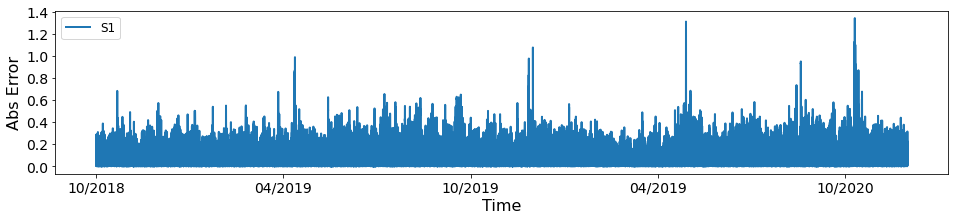

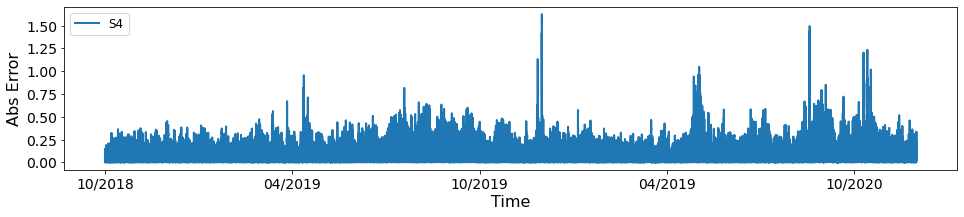

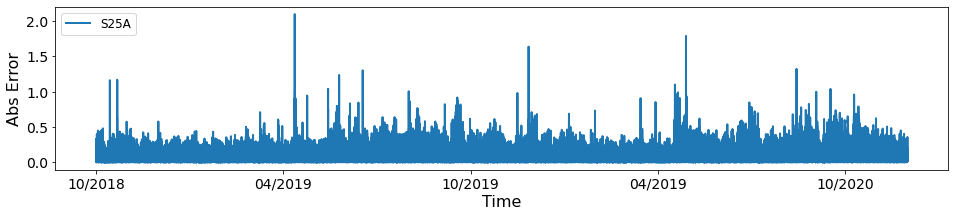

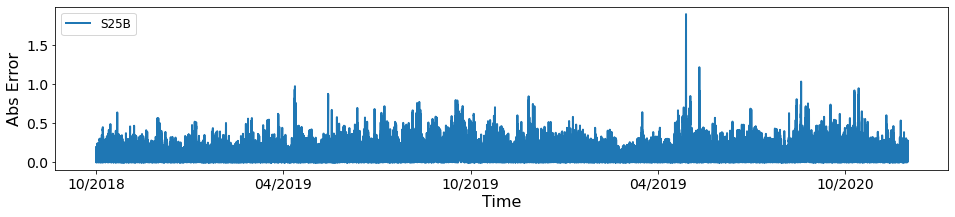

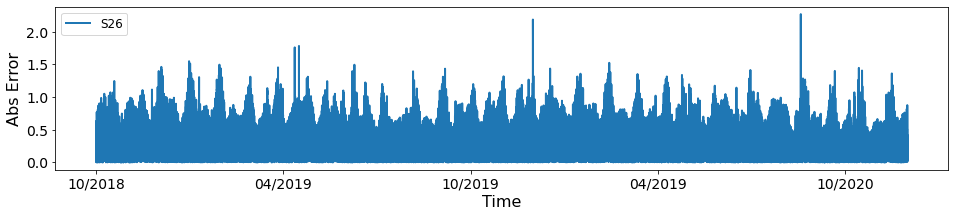

In [108]:
# visualize water stage error seperately
for i in range(5):
    plt.rcParams["figure.figsize"] = (16, 3)
    error = abs(inv_yhat.iloc[:, i] - inv_y.iloc[:, i])
    plt.plot(error, label='{}'.format(station[i]), linewidth=2)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Abs Error', fontsize=16)
    plt.xticks(np.arange(0, len(inv_y), 26675), date, fontsize=14)  # len(inv_y) = 115593
    plt.yticks(fontsize=14)
    plt.legend(fontsize=12, loc='upper left')
    plt.show()
    plt.close()

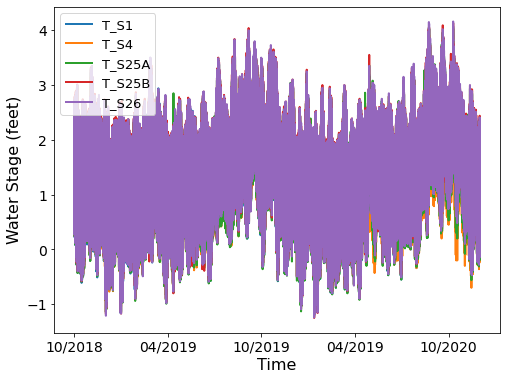

In [109]:
# visualize the predicted value of WS

date = ['10/2018', '04/2019', '10/2019', '04/2019', '10/2020']
# station = ['WS_S1', 'WS_S4', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
station = ['S1', 'S4', 'S25A', 'S25B', 'S26']

for i in range(5):
    plt.rcParams["figure.figsize"] = (8, 6)
    # plt.plot(inv_yhat.iloc[:, i], label='Pred_{}'.format(station[i]), linewidth=2)
    plt.plot(inv_y.iloc[:, i], label='T_{}'.format(station[i]), linewidth=2)
    # plt.title('Predicted & Actual Value of {}'.format(station[i]), fontsize=18)
    # plt.text(99858, 3.35, 'MAE: {:.4f}'.format(MAE_WS_S1), fontsize=13)
    
plt.xlabel('Time', fontsize=16)
plt.ylabel('Water Stage (feet)', fontsize=16)
plt.xticks(np.arange(0, len(inv_y), 26675), date, fontsize=14)  # len(inv_y) = 115593
plt.yticks(fontsize=14)
plt.legend(fontsize=13, loc='upper left')
plt.show()
plt.close()